In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
data = pd.read_csv("./Datasets/cybersecurity_intrusion_data.csv")
data

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9532,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1
9533,SID_09534,380,TCP,3,182.848475,NaN,0.408485,0,Chrome,0,0
9534,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0
9535,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0


### Descriptive analysis of your data

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


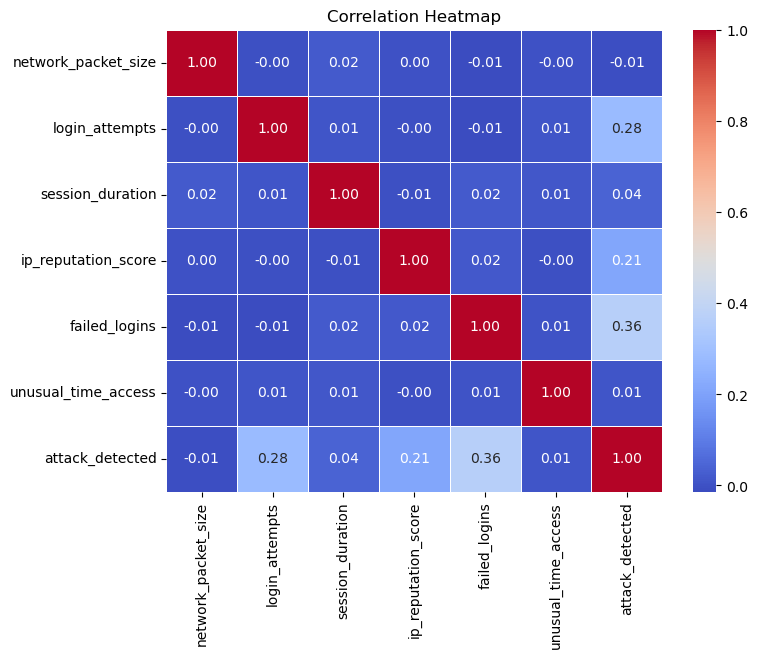

In [14]:
# Correlation matrix, only for numerical values
num_values = ["network_packet_size", "login_attempts", "session_duration","ip_reputation_score","failed_logins","unusual_time_access","attack_detected"]
matrix = data[num_values].corr()
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [35]:
# We can observe that login_attempts, ip_reputation_score, failed_login are the most correlated features to attack_detected

In [16]:
df = pd.DataFrame(data=data.values, columns=data.columns)

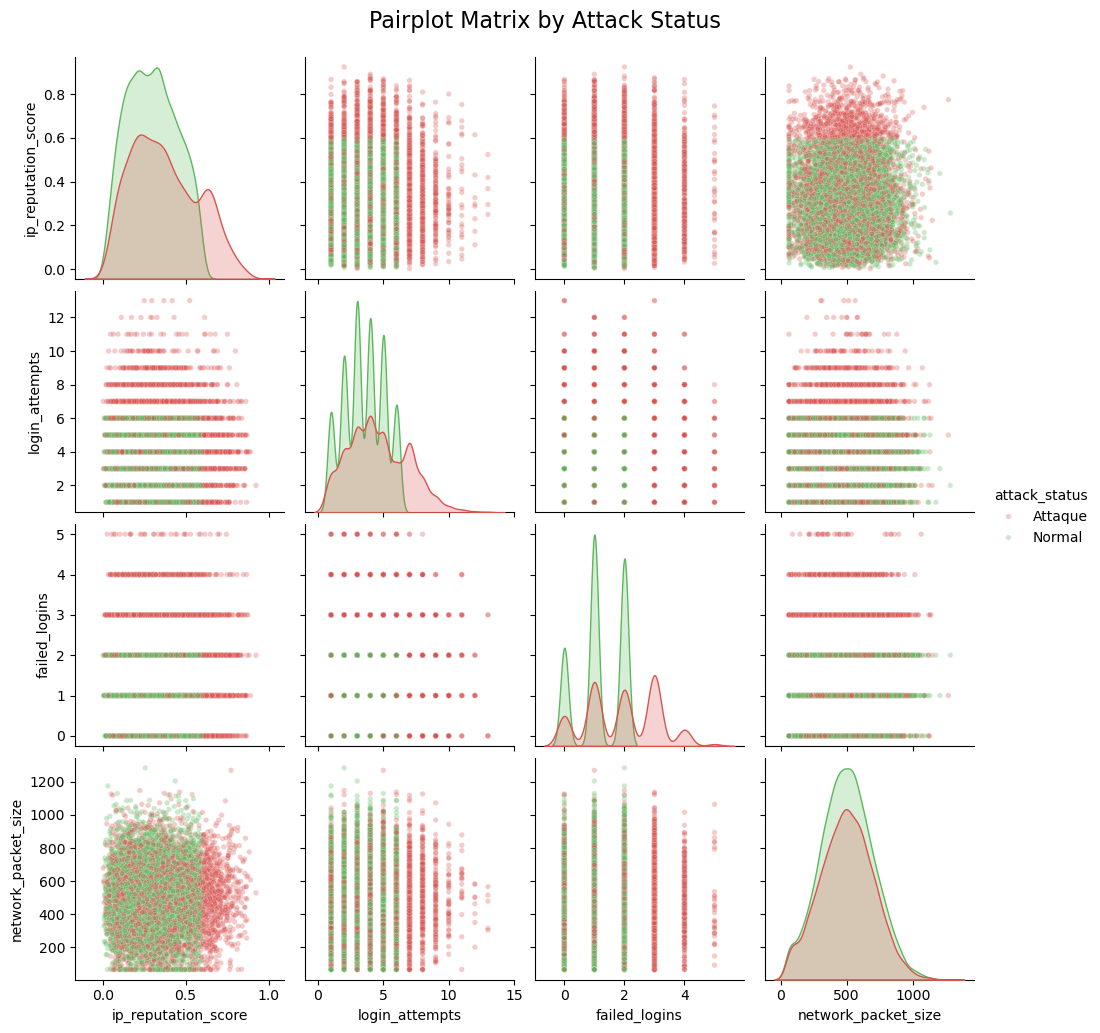

In [ ]:
# Convert the numerical 'attack_detected' column (0 or 1)
# into a categorical string ('Attack' or 'Normal') for the legend.
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attack' if x == 1 else 'Normal')

# --- Data Preparation ---
# Select a subset of columns to plot.
# A full pairplot with all columns would be too large and unreadable.
columns_to_plot = [
    'ip_reputation_score',
    'login_attempts',
    'failed_logins',
    'network_packet_size',
    'attack_status',# This column will be used for coloring ('hue')
]

# Create a new DataFrame from the selected columns.
# .copy() is used to avoid a 'SettingWithCopyWarning' from pandas.
df_subset = df[columns_to_plot].copy()

# --- Create and Display the Plot ---
# 'sns.pairplot' creates a grid of scatterplots for every pair of columns.
# The diagonal plots are histograms (or density plots) for each variable.
g = sns.pairplot(
    df_subset, 
    hue='attack_status', # Color the points based on the 'attack_status' column
    palette={'Normal': '#5CB85C', 'Attack': '#D9534F'}, # Assign custom colors (Green/Red)
    plot_kws={'alpha': 0.3, 's': 15} # 'plot_kws' arguments:
                                     # 'alpha=0.3' makes points 30% transparent to see overlaps
                                     # 's=15' sets the size of the points
)


g.fig.suptitle("Pairplot Matrix by Attack Status", y=1.03, fontsize=16)
plt.show()

In [ ]:
# The pairplot analysis highlights clear differences between normal and attack instances. 
# Features such as ip_reputation_score, login_attempts, and failed_logins show strong discriminative power: attack samples tend to have lower IP reputation scores 
# and higher login attempts and failures. 
# In contrast, network_packet_size shows little distinction between the two classes. 
# The observed correlation between login_attempts and failed_logins is coherent. 
# Overall, these insights indicate that the dataset is well-suited for binary supervised learning

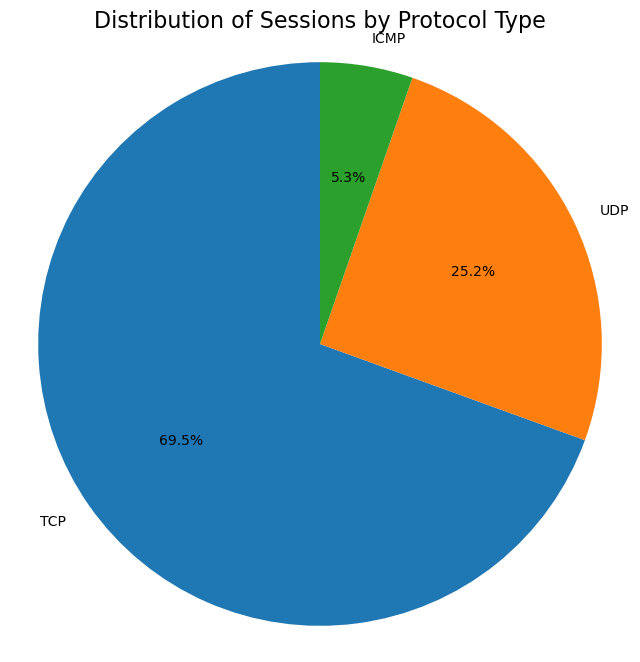

In [22]:
# --- Pie Chart 1: Protocol Type ---

# 1. Get the data for the pie chart
# .value_counts() calculates the size of each slice
protocol_counts = df['protocol_type'].value_counts()

# 2. Get the labels (e.g., 'TCP', 'UDP', 'ICMP')
protocol_labels = protocol_counts.index

# 3. Get the numerical values (the counts for each slice)
protocol_sizes = protocol_counts.values

plt.figure(figsize=(8, 8)) # Set the figure size to be a square
plt.pie(
    protocol_sizes,      # The numerical values for each slice
    labels=protocol_labels, # The text labels for each slice
    autopct='%1.1f%%',   # Format to show percentages (e.g., '10.1%')
    startangle=90        # Start the first slice at the 90-degree (top) position
)

plt.title('Distribution of Sessions by Protocol Type', fontsize=16)
plt.axis('equal') 
plt.show()

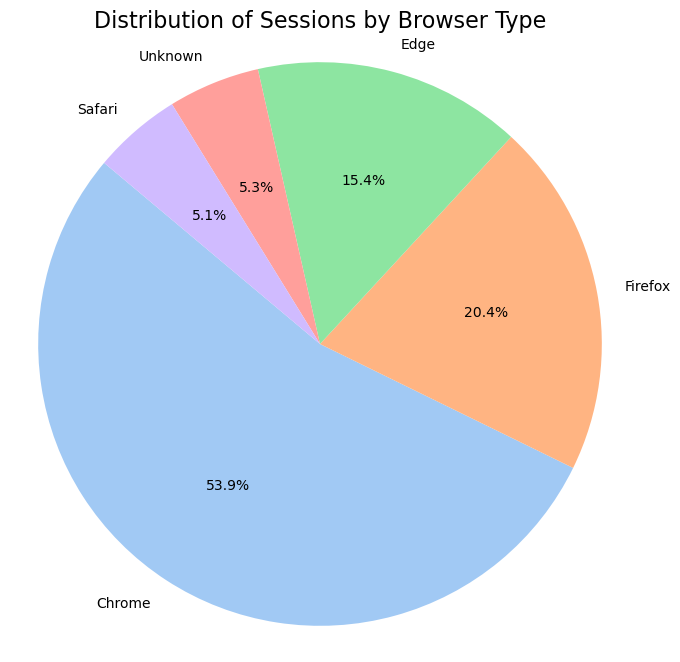

In [24]:
# --- Pie Chart 2: Browser Type (with explode) ---

# 1. Get the data
browser_counts = df['browser_type'].value_counts()
browser_labels = browser_counts.index
browser_sizes = browser_counts.values


colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(8, 8))
plt.pie(
    browser_sizes,
    labels=browser_labels,
    autopct='%1.1f%%',
    startangle=140,       # Start at a different angle
    colors=colors         # Apply the custom color palette
)


plt.title('Distribution of Sessions by Browser Type', fontsize=16)
plt.axis('equal')
plt.show()

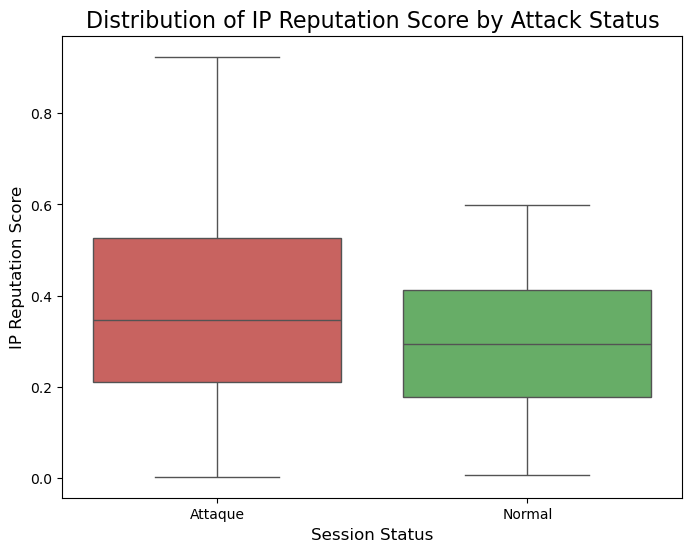

In [ ]:
# Convert the 'attack_detected' column (0 or 1) into a string
# This makes the plot labels ('Attack' / 'Normal') more readable
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attack' if x == 1 else 'Normal')

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df,                      
    x='attack_status',           
    y='ip_reputation_score',    
    
    # 1. Assign the x-variable ('attack_status') to 'hue'
    hue='attack_status',
    palette={'Normal': '#5CB85C', 'Attack': '#D9534F'}, 
    legend=False                  

)

plt.title('Distribution of IP Reputation Score by Attack Status', fontsize=16)
plt.xlabel('Session Status', fontsize=12)
plt.ylabel('IP Reputation Score', fontsize=12)
plt.show()

In [ ]:
# This box plot compares the IP Reputation Score for "Normal" (green) and "Attaque" (red) sessions, revealing that attacks are strongly 
# correlated with higher reputation scores. We can clearly see the red box (Attaque) is positioned significantly higher on the graph, 
# with a median score around 0.38, compared to the green box (Normal) which has a lower median of approximately 0.25. This difference 
# demonstrates that ip_reputation_score is a valuable indicator for identifying malicious activity, as a high score is a major red flag, 
# even though outliers show some attacks can still come from low-reputation IPs.

### Pre-processing

In [43]:
# Vérification de null ou NaN
print("Number of Null :\n",data.isnull().sum())

# We will drop every null row
data_cleaned = data.dropna(axis=0)
print("\nNumber of Null :\n",data_cleaned.isnull().sum())

# session_id here is not relevant
data_cleaned = data_cleaned.drop("session_id", axis=1)

Number of Null :
 session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

Number of Null :
 session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64


In [45]:
print(data_cleaned["browser_type"].value_counts())
print(data_cleaned["encryption_used"].value_counts())
print(data_cleaned["protocol_type"].value_counts())

browser_type
Chrome     4082
Firefox    1527
Edge       1183
Unknown     397
Safari      382
Name: count, dtype: int64
encryption_used
AES    4706
DES    2865
Name: count, dtype: int64
protocol_type
TCP     5235
UDP     1941
ICMP     395
Name: count, dtype: int64


Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:0.50


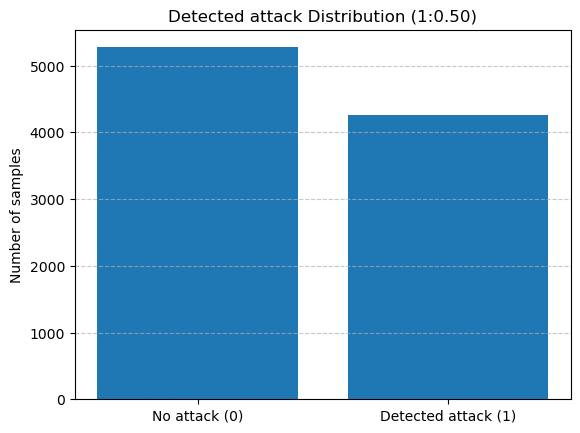

In [47]:
### Class distribution
X, y = data_cleaned.drop("attack_detected", axis=1), data_cleaned["attack_detected"]

class_counts = data['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)
minority = class_counts.min()
majority = class_counts.max()
ratio = minority/(minority+minority)
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['No attack (0)', 'Detected attack (1)'], class_counts)
plt.title(f"Detected attack Distribution (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# We have a slight imbalance that we can correct by either undersampling the minority class 0 or oversampling 
# the majority class 1, with random under/oversampling or SMOTE